1.0
1.0


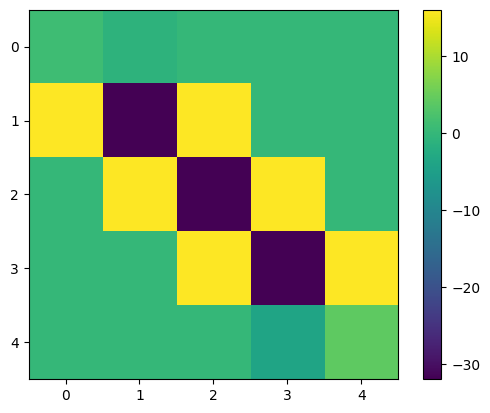

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def solve_bvp(N):
    h = 1.0 / N
    x = np.linspace(0, 1, N+1)

    # Matrix A and RHS b
    A = np.zeros((N+1, N+1))
    b = np.ones(N+1)

    # Interior points
    for i in range(1, N):
        A[i, i-1] = 1.0 / h**2
        A[i, i]   = -2.0 / h**2
        A[i, i+1] = 1.0 / h**2
        b[i] = 1.0  # from u''=1

    # Neumann BC at x=0: u'(0)=0  → (u1 - u_{-1})/(2h)=0 → u0 - u1 = 0
    A[0,0] = 1.0
    A[0,1] = -1.0
    b[0] = 0.0

    # Neumann BC at x=1: u'(1)=1 → (u_{N+1} - u_{N-1})/(2h)=1
    # Approximate with (uN - u_{N-1})/h = 1  (second-order one-sided)
    A[N,N]   = 1.0 / h
    A[N,N-1] = -1.0 / h
    b[N] = 1.0

    # Add integral constraint as last equation
    # A = np.vstack([A, np.ones(N+1)*h])
    # b = np.append(b, 1.0)

    plt.imshow(A)
    plt.colorbar()

    # Solve least squares (since extra eqn makes system overdetermined)
    u, *_ = np.linalg.lstsq(A, b, rcond=None)

    return x, u
from scipy.integrate import simpson
n=4
x,u = solve_bvp(n)
u /= simpson(u,x)  # Normalize
print(simpson(u,x))
x = np.linspace ( 0. , 1. , n+1 )
an =  0.5*x**2+5/6
# an /= simpson(an)
print(simpson(an,x))
# plt.plot( x , 0.5*x**2+5/6 ,label='Analytic');
# plt.plot(x,u);
# plt.legend()

In [ ]:
import numpy as np
from time import perf_counter

def build_a_on_grid(a_func, N):
    # build a_{i,j} on full grid including boundaries (size N+2)
    h = 2.0/(N+1)
    xs = np.linspace(-1,1,N+2)
    ys = np.linspace(-1,1,N+2)
    a = np.empty((N+2, N+2))
    for j in range(N+2):
        for i in range(N+2):
            a[i,j] = a_func(xs[i], ys[j])
    return a, h

def sor_variable_a(a, f, N, omega, tol=1e-8, maxit=20000, verbose=False):
    """
    SOR solver for -div(a grad u) = f on interior NxN grid, zero Dirichlet on boundary.
    a: (N+2)x(N+2) array of a values including boundary
    f: NxN array (interior right-hand side values)
    returns u (N+2 x N+2 with boundary zeros), num_iters, residual history last residual
    """
    h = 2.0/(N+1)
    h2 = h*h
    # precompute weights
    wE = 2.0/(3.0*h2)
    wD = 1.0/(6.0*h2)
    wC = -10.0/(3.0*h2)

    # initialize u (including boundaries) — Dirichlet 0 on boundary
    U = np.zeros((N+2, N+2))
    # convenience slice views
    # interior indices i=1..N, j=1..N
    iters = 0
    # compute initial residual to check convergence
    def local_residual(i,j):
        ai = a[i,j]
        Ax = (a[i+1,j]-a[i-1,j])/(4.0*h2)
        Ay = (a[i,j+1]-a[i,j-1])/(4.0*h2)
        # Laplacian 9-point part
        lap = (4.0*(U[i+1,j] + U[i-1,j] + U[i,j+1] + U[i,j-1]) +
               (U[i+1,j+1] + U[i+1,j-1] + U[i-1,j+1] + U[i-1,j-1]) - 20.0*U[i,j])/(6.0*h2)
        gradprod = ( (a[i+1,j]-a[i-1,j])*(U[i+1,j]-U[i-1,j]) + (a[i,j+1]-a[i,j-1])*(U[i,j+1]-U[i,j-1]) )/(4.0*h2)
        return -(ai*lap + gradprod) - f[i-1,j-1]  # residual at (i,j), note f indexed 0..N-1

    # compute initial residual norm
    res0 = 0.0
    for j in range(1,N+1):
        for i in range(1,N+1):
            r = local_residual(i,j)
            res0 += r*r
    res0 = np.sqrt(res0)
    if res0 == 0: res0 = 1.0
    tol_abs = tol * res0

    while iters < maxit:
        max_update = 0.0
        # red-black ordering is possible; here we do simple lexicographic Gauss-Seidel with SOR
        for j in range(1, N+1):
            for i in range(1, N+1):
                ai = a[i,j]
                Ax = (a[i+1,j]-a[i-1,j])/(4.0*h2)
                Ay = (a[i,j+1]-a[i,j-1])/(4.0*h2)

                # coefficients (as in derivation)
                c_center = ai * wC
                c_ip1j = ai * wE - Ax
                c_im1j = ai * wE + Ax
                c_ijp1 = ai * wE - Ay
                c_ijm1 = ai * wE + Ay
                c_diag = ai * wD  # for four diagonal neighbors

                # sum contributions from neighbors (excluding center)
                neigh_sum = (c_ip1j * U[i+1,j] + c_im1j * U[i-1,j] +
                             c_ijp1 * U[i,j+1] + c_ijm1 * U[i,j-1] +
                             c_diag * (U[i+1,j+1] + U[i+1,j-1] + U[i-1,j+1] + U[i-1,j-1]))

                # Solve for new u_ij:
                # c_center * u_ij + neigh_sum = f_ij  => u_ij = (f_ij - neigh_sum)/c_center
                # Note: c_center is negative; we proceed algebraically
                rhs_val = f[i-1, j-1] - neigh_sum
                new_u = rhs_val / c_center

                # SOR update
                old_u = U[i,j]
                u_update = (1.0 - omega)*old_u + omega * new_u
                U[i,j] = u_update
                max_update = max(max_update, abs(u_update - old_u))

        iters += 1

        # check residual every 10 iterations for speed
        if iters % 10 == 0:
            res_norm = 0.0
            for jj in range(1, N+1):
                for ii in range(1, N+1):
                    r = local_residual(ii,jj)
                    res_norm += r*r
            res_norm = np.sqrt(res_norm)
            if res_norm <= tol_abs:
                return U, iters, res_norm
        # cheap stagnation check
        if max_update < 1e-12:
            break

    # final residual
    res_norm = 0.0
    for jj in range(1, N+1):
        for ii in range(1, N+1):
            r = local_residual(ii,jj)
            res_norm += r*r
    res_norm = np.sqrt(res_norm)
    return U, iters, res_norm

def find_opt_omega(a_func, f_func, N, omegas, tol=1e-8, maxit=20000):
    """
    Sweep supplied omega list and return iteration counts and residuals.
    a_func(x,y) and f_func(x,y) provide continuous definitions.
    """
    a, h = build_a_on_grid(a_func, N)
    _, h = a.shape, 2.0/(N+1)  # not used; keep consistent
    # build f interior as NxN
    xs = np.linspace(-1,1,N+2)
    ys = np.linspace(-1,1,N+2)
    f = np.zeros((N,N))
    for j in range(1,N+1):
        for i in range(1,N+1):
            f[i-1,j-1] = f_func(xs[i], ys[j])

    results = []
    for omega in omegas:
        t0 = perf_counter()
        U, its, res = sor_variable_a(a, f, N, omega, tol=tol, maxit=maxit)
        t1 = perf_counter()
        results.append({'omega':omega, 'iters':its, 'res':res, 'time':t1-t0})
        print(f"omega={omega:.4f}: iters={its}, res={res:.2e}, time={t1-t0:.3f}s")
    return results
res_ls= []
it_ls=[]
# Example usage:
if __name__ == "__main__":
    # define a(x,y) and f(x,y)
    def a_func(x,y):
        return 1.0 + 0.5*np.sin(np.pi*x)*np.sin(np.pi*y)  # smooth positive coefficient

    def f_func(x,y):
        return 2.0  # simple RHS (for testing)

    N = 40
    omegas = np.linspace(0.1, 1.95, 3)
    res = find_opt_omega(a_func, f_func, N, omegas, tol=1e-6, maxit=5000)


omega=0.1000: iters=5000, res=1.77e+02, time=49.292s
omega=1.0250: iters=3094, res=1.91e+02, time=28.760s
omega=1.9500: iters=527, res=1.91e+02, time=4.598s


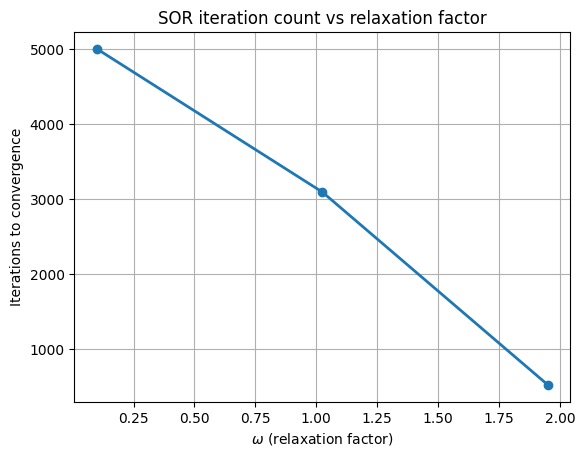

In [11]:
import matplotlib.pyplot as plt

# Suppose you already have 'res' from find_opt_omega(...)
omegas = [r['omega'] for r in res]
iters = [r['iters'] for r in res]

plt.figure()
plt.plot(omegas, iters, 'o-', lw=2)
plt.xlabel(r'$\omega$ (relaxation factor)')
plt.ylabel('Iterations to convergence')
plt.title('SOR iteration count vs relaxation factor')
plt.grid(True)
plt.show()
